In [15]:
import pandas as pd
import nltk
import re
from nltk.corpus import stopwords
import time
import numpy as np
import pandas as pd
import re
import nltk

nltk.download('punkt_tab')
nltk.download('stopwords')


df = pd.read_csv("./Startups_newfile.csv", encoding='ISO-8859-1')
df.head()


[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/hitmonlee/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/hitmonlee/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,Incubation Center,Name of the startup,Location of company,Sector,Company profile,Sector_Normalized,Sector_Group,Class
0,SIIC IIT KANPUR,E-Trainer Analytics Wizard Pvt ltd,New Delhi,Fit-Tech,"Fitbuddy, a flagship brand under E-Trainer Ana...",fittech,Healthcare & Biotech,C
1,SIIC IITK,Invariance Automation Private Limited,"Kanpur, UP",Industrial Automation,Currently we are developing the infrastructure...,industrialautomation,Information & Deep Technology,D
2,"SIIC, IIT Kanpur",Neoperk Technologies Pvt. Ltd.,"Mumbai, Maharashtra",Agri-Tech - Soil Testing,Neoperk makes large scale soil testing extreme...,agritechsoiltesting,Agriculture & Environment,A
3,SIIC IIT KANPUR,WeRehab Technologies Pvt Ltd,Nagpur,Health tech,WeRehab Technologies Pvt Ltd. Is a startup fou...,healthtech,Healthcare & Biotech,C
4,IIT Kanpur,Arthavedika Tech Pvt Ltd,"Noida, Uttar Pradesh",Fintech,Arthavedika Tech Pvt Ltd is a DIPP certified t...,fintech,Information & Deep Technology,D


In [16]:
def preprocess_text(text: str) -> str:
    # remove links
    text = re.sub(r"http\S+", "", text)
    # remove special chars and numbers
    text = re.sub("[^A-Za-z]+", " ", text)
    
    # remove stopwords
    tokens = nltk.word_tokenize(text)
    tokens = [w for w in tokens if not w.lower() in stopwords.words("english")]
    text = " ".join(tokens)
    text = text.lower().strip()
    
    return text


In [39]:
df.columns = df.columns.str.replace(" ","_").str.lower()

df['processed'] = df['company_profile'].dropna().apply(preprocess_text)
df = df.loc[~df['processed'].isna()]

In [18]:
# TF-IDF Vectorization

from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(sublinear_tf=True, min_df=2, max_df=0.95)
X = vectorizer.fit_transform(df['processed']).toarray()

In [19]:
# Sentence Transformer

from sentence_transformers import SentenceTransformer

st = time.time()

model = SentenceTransformer('paraphrase-MiniLM-L6-v2')
df['encode_transforemers'] = df['processed'].apply(lambda text: model.encode(text, convert_to_numpy=True).flatten())

et = time.time()

print("Elapsed time: {:.2f} seconds".format(et - st))


X_transformers = np.vstack(df['encode_transforemers'])

Elapsed time: 7.43 seconds


In [20]:
# GloVe

from torchtext.vocab import GloVe

embeddings = GloVe(name='6B', dim=100)

# Set the maximum sentence length and embedding dimension
max_length = 100 
embedding_dim = 100

# define a function to convert a sentence to a fixed-size vector using GloVe embeddings
def sentence_embedding(sentence):
    words = sentence.split()
    num_words = min(len(words), max_length)
    embedding_sentence = np.zeros((max_length, embedding_dim))
    
    for i in range(num_words):
        word = words[i]
        if word in embeddings.stoi:
            embedding_sentence[i] = embeddings.vectors[embeddings.stoi[word]]
            
    return embedding_sentence.flatten()

df['encode_glove'] = df['processed'].apply(lambda sentence: sentence_embedding(sentence))
X_glove = np.vstack(df['encode_glove'])

/tmp/ipykernel_4122/2997349109.py:20: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  embedding_sentence[i] = embeddings.vectors[embeddings.stoi[word]]


In [21]:
# BERT-cls

from transformers import BertTokenizer
from transformers import BertModel
import torch

# Load pre-trained BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

def get_cls_sentence(sentence):
    # Tokenize input sentence and convert to tensor
    input_ids = torch.tensor([tokenizer.encode(sentence, add_special_tokens=True, max_length=512)])

    # Pass input through BERT model and extract embeddings for [CLS] token
    with torch.no_grad():
        outputs = model(input_ids)
        cls_embedding = outputs[0][:, 0, :]
    
    return cls_embedding.flatten()

In [22]:
st = time.time()

df['cls_bert'] = df['processed'].apply(lambda sentence: get_cls_sentence(sentence))

et = time.time()

print("Elapsed time: {:.2f} seconds".format(et - st))

X_cls_bert = np.vstack(df['cls_bert'])

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Elapsed time: 20.41 seconds


In [48]:
from sklearn.cluster import KMeans
from sklearn.metrics.cluster import adjusted_rand_score, normalized_mutual_info_score, fowlkes_mallows_score

def eval_cluster(embeddings):
    kmeans = KMeans(n_clusters=5, random_state=42,n_init=10,init="k-means++")
    y_pred = kmeans.fit_predict(embeddings)

    
    # Evaluate the performance using ARI, NMI, and FMI
    ari = adjusted_rand_score(df["class"], y_pred)
    nmi = normalized_mutual_info_score(df["class"], y_pred)
    fmi = fowlkes_mallows_score(df["class"], y_pred)

    # Print Metrics scores
    print("Adjusted Rand Index (ARI): {:.3f}".format(ari))
    print("Normalized Mutual Information (NMI): {:.3f}".format(nmi))
    print("Fowlkes-Mallows Index (FMI): {:.3f}".format(fmi))


In [44]:
from sklearn.decomposition import PCA

def dimension_reduction(embedding, method):

    pca = PCA(n_components=2, random_state=42)

    pca_vecs = pca.fit_transform(embedding)

    # save our two dimensions into x0 and x1
    x0 = pca_vecs[:, 0]
    x1 = pca_vecs[:, 1]
    
    df[f'x0_{method}'] = x0 
    df[f'x1_{method}'] = x1

In [45]:
from matplotlib import pyplot as plt
import seaborn as sns

def plot_pca(x0_name, x1_name, cluster_name, method):

    plt.figure(figsize=(12, 7))

    plt.title(f"TF-IDF + KMeans StartUp in India clustering with {method}", fontdict={"fontsize": 18})
    plt.xlabel("X0", fontdict={"fontsize": 16})
    plt.ylabel("X1", fontdict={"fontsize": 16})

    sns.scatterplot(data=df, x=x0_name, y=x1_name, hue=cluster_name, palette="viridis")
    plt.show()

In [37]:
def map_cluster_to_truth(df: pd.DataFrame,cluster_col: pd.Series,truth_col: pd.Series) -> pd.Series:
    
    cluster_to_label_map = df.groupby(cluster_col)[truth_col].agg(lambda x: x.mode().iloc[0]).to_dict()
    predicted_labels = df[cluster_col].map(cluster_to_label_map)

    return predicted_labels


Accuracy for tfidf: 0.3529
Adjusted Rand Index (ARI): -0.011
Normalized Mutual Information (NMI): 0.041
Fowlkes-Mallows Index (FMI): 0.460


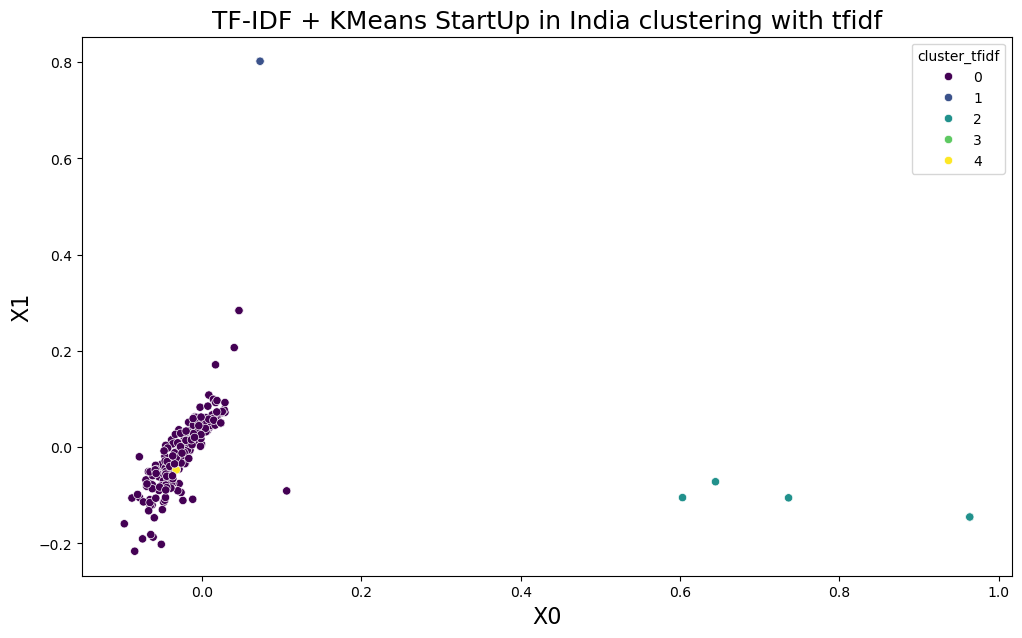

Accuracy for transformers: 0.4202
Adjusted Rand Index (ARI): 0.091
Normalized Mutual Information (NMI): 0.162
Fowlkes-Mallows Index (FMI): 0.350


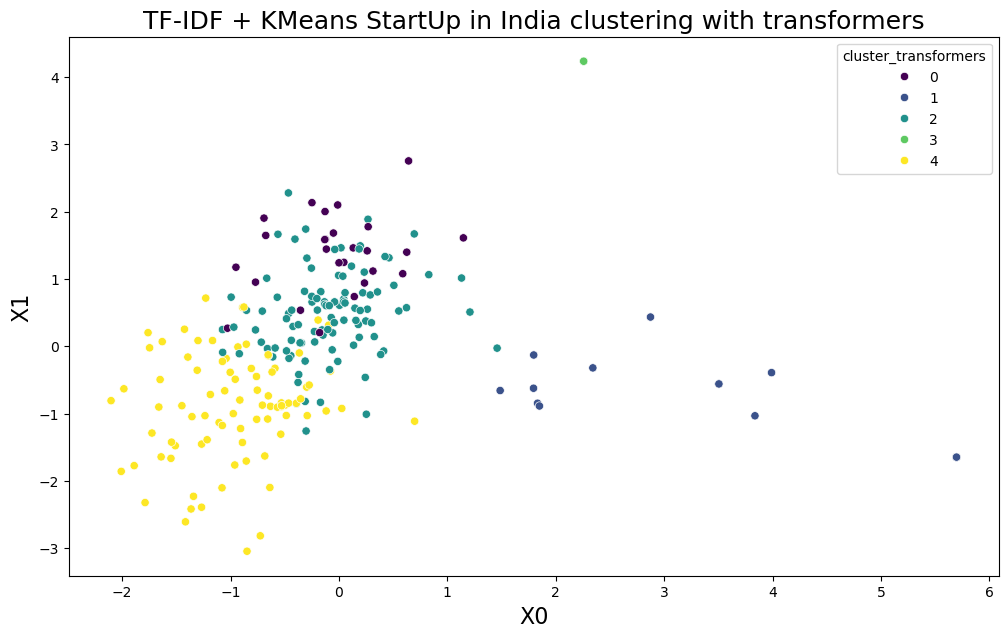

Accuracy for glove: 0.3571
Adjusted Rand Index (ARI): 0.020
Normalized Mutual Information (NMI): 0.046
Fowlkes-Mallows Index (FMI): 0.434


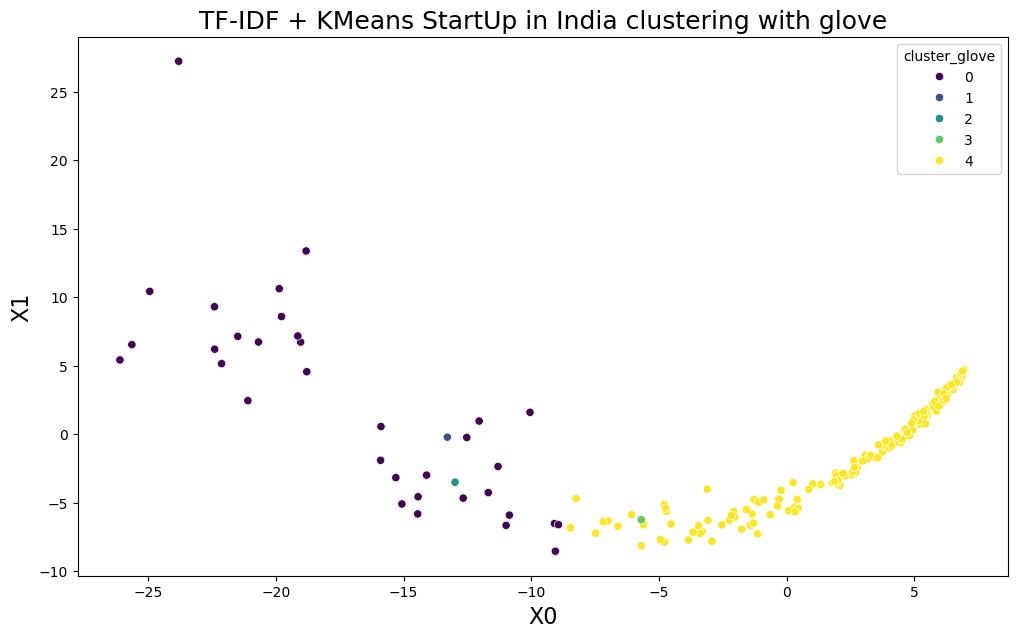

Accuracy for Bert-CLS: 0.3529
Adjusted Rand Index (ARI): 0.003
Normalized Mutual Information (NMI): 0.047
Fowlkes-Mallows Index (FMI): 0.253


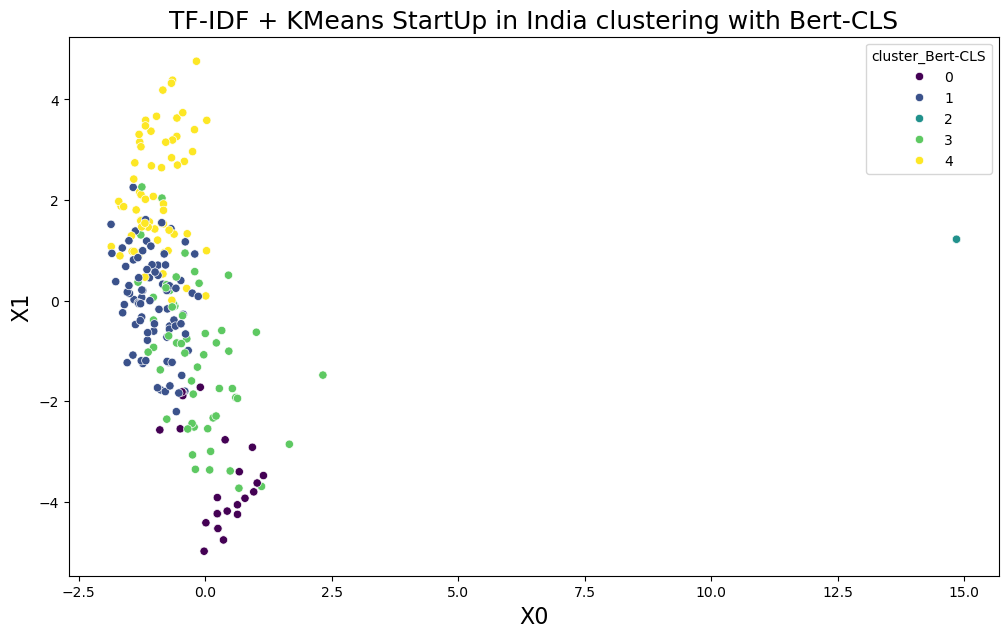

In [49]:
from sklearn.metrics import accuracy_score

source_of_truth_col = "class"

for embedding_and_method in [(X, 'tfidf'), (X_transformers, 'transformers'), (X_glove, 'glove'), (X_cls_bert, 'Bert-CLS')]:
    embedding, method = embedding_and_method[0], embedding_and_method[1]
    
    
    kmeans = KMeans(n_clusters=5, random_state=42,n_init=10,init="k-means++")
    kmeans.fit(embedding)
    
    clusters = kmeans.labels_
    
    clusters_result_name = f'cluster_{method}'
    df[clusters_result_name] = clusters
    
    predicted_label_name = f'predicted_label_{method}'
    df[predicted_label_name] = map_cluster_to_truth(df, clusters_result_name, source_of_truth_col)
    
    accuracy = accuracy_score(df[source_of_truth_col], df[predicted_label_name])
    print(f"Accuracy for {method}: {accuracy:.4f}")
    

    eval_cluster(embedding)
    dimension_reduction(embedding, method)
    plot_pca(f'x0_{method}', f'x1_{method}', cluster_name=clusters_result_name, method=method)



In [29]:
df.columns

Index(['incubation_center', 'name_of_the_startup', 'location_of_company',
       'sector', 'company_profile', 'sector_normalized', 'sector_group',
       'class', 'processed', 'encode_transforemers', 'encode_glove',
       'cls_bert', 'cluster_tfidf', 'predicted_label_tfidf', 'x0_tfidf',
       'x1_tfidf', 'cluster_transformers', 'predicted_label_transformers',
       'x0_transformers', 'x1_transformers', 'cluster_glove',
       'predicted_label_glove', 'x0_glove', 'x1_glove', 'cluster_Bert-CLS',
       'predicted_label_Bert-CLS', 'x0_Bert-CLS', 'x1_Bert-CLS'],
      dtype='object')

In [50]:
df.loc[:,["sector_group","class","cluster_tfidf","cluster_transformers","cluster_glove","cluster_Bert-CLS"]]

,sector_group,class,cluster_tfidf,cluster_transformers,cluster_glove,cluster_Bert-CLS
0,Healthcare & Biotech,C,0,2,4,1
1,Information & Deep Technology,D,0,4,4,3
2,Agriculture & Environment,A,0,4,0,4
3,Healthcare & Biotech,C,0,2,0,4
4,Information & Deep Technology,D,0,2,0,4
...,...,...,...,...,...,...
236,Information & Deep Technology,D,0,2,4,4
237,Other / Multi-sector,E,0,4,4,1
238,Other / Multi-sector,E,0,4,4,1
239,Healthcare & Biotech,C,0,4,4,3
